In [3]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [4]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
portfolio_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [5]:
price = vbt.YFData.download('BTC-USD').get('Close')

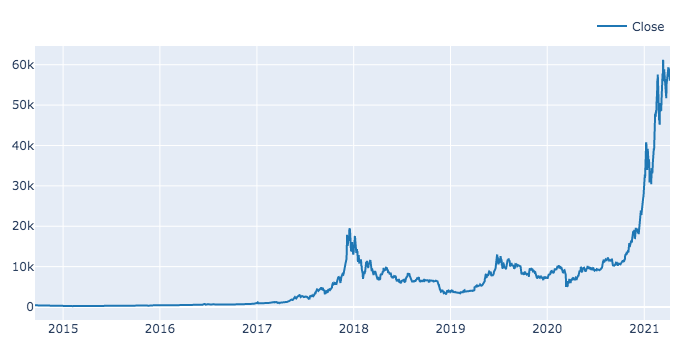

In [6]:
price.vbt.plot().show_png()

In [7]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

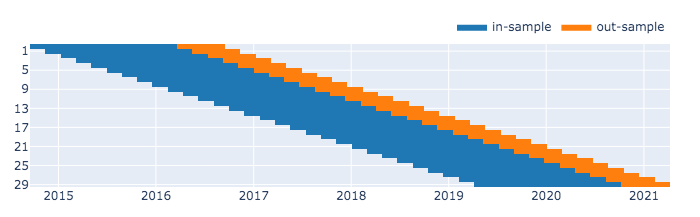

In [8]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_png()

In [9]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [10]:
def simulate_holding(price, **kwargs):
    portfolio = vbt.Portfolio.from_holding(price, **kwargs)
    return portfolio.sharpe_ratio()

In [11]:
in_hold_sharpe = simulate_holding(in_price, **portfolio_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.407739
2     1.238545
3     1.249842
4     1.588366
5     1.904711
6     2.287450
7     2.014816
8     2.312212
9     2.798775
10    2.780599
11    3.149183
12    2.343529
13    2.259943
14    2.097648
15    2.033325
16    1.787817
17    1.242690
18    0.885305
19    0.393669
20    0.310376
21    0.130126
22    0.245234
23    0.368319
24    0.504229
25    0.750594
26    0.484766
27    1.259002
28    1.400597
29    1.058635
Name: sharpe_ratio, dtype: float64


In [27]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    print(exits)
    print(price)
    return portfolio.sharpe_ratio()


# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **portfolio_kwargs)

print(in_sharpe)

fast_window     10                                                          \
slow_window     11                                                           
split_idx       0      1      2      3      4      5      6      7      8    
0            False  False  False  False  False  False  False  False  False   
1            False  False  False  False  False  False  False  False  False   
2            False  False  False  False  False  False  False  False  False   
3            False  False  False  False  False  False  False  False  False   
4            False  False  False  False  False  False  False  False  False   
..             ...    ...    ...    ...    ...    ...    ...    ...    ...   
545          False  False  False  False  False  False  False  False   True   
546          False  False  False  False  False  False  False   True  False   
547          False  False   True  False  False  False  False  False  False   
548          False  False  False  False  False  False  False  Fa

In [13]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [14]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (23, 25,  4),
            (20, 41,  5),
            (41, 42,  6),
            (40, 43,  7),
            (37, 43,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 21, 15),
            (10, 22, 16),
            (10, 22, 17),
            (11, 21, 18),
            (17, 22, 19),
            (17, 22, 20),
            (13, 21, 21),
            (13, 21, 22),
            (18, 21, 23),
            (45, 49, 24),
            (18, 21, 25),
            (13, 21, 26),
            (13, 21, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [15]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [16]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [23 25]
 [20 41]
 [41 42]
 [40 43]
 [37 43]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [11 21]
 [17 22]
 [17 22]
 [13 21]
 [13 21]
 [18 21]
 [45 49]
 [18 21]
 [13 21]
 [13 21]
 [13 20]
 [13 20]]


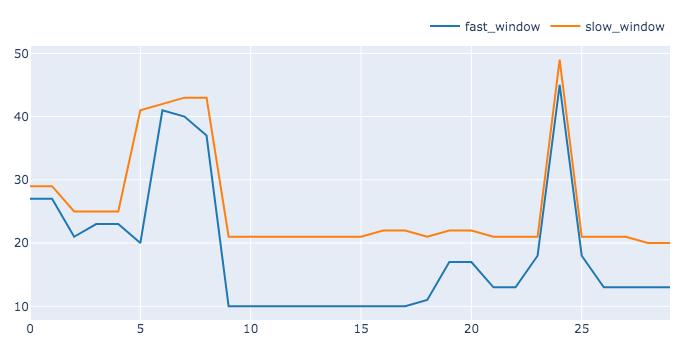

In [17]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_png()

In [18]:
out_hold_sharpe = simulate_holding(out_price, **portfolio_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     2.018748
2     1.755721
3     3.128743
4     2.692203
5     2.913636
6     3.541160
7     3.860226
8     4.300998
9     1.832342
10    0.882911
11   -0.851117
12    0.132318
13    0.192643
14   -2.068312
15   -2.328601
16   -1.382621
17    1.542028
18    3.224538
19    2.850866
20    1.346376
21   -1.245475
22   -0.388867
23   -0.028626
24    1.139813
25    0.934133
26    2.097729
27    3.147384
28    4.211338
29    4.764318
Name: sharpe_ratio, dtype: float64


In [19]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **portfolio_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -1.233168
                          2            1.732389
                          3            0.743637
                          4            1.797290
                                         ...   
48           49           25          -1.147262
                          26          -2.360149
                          27           0.364875
                          28           3.297214
                          29           3.786454
Name: sharpe_ratio, Length: 23400, dtype: float64


In [20]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [21]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **portfolio_kwargs)

print(out_test_sharpe)

(180, 30) (180, 30)
MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (23, 25,  4),
            (20, 41,  5),
            (41, 42,  6),
            (40, 43,  7),
            (37, 43,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 21, 15),
            (10, 22, 16),
            (10, 22, 17),
            (11, 21, 18),
            (17, 22, 19),
            (17, 22, 20),
            (13, 21, 21),
            (13, 21, 22),
            (18, 21, 23),
            (45, 49, 24),
            (18, 21, 25),
            (13, 21, 26),
            (13, 21, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['ma_window', 'ma_window', 'split_idx']) Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2

In [22]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

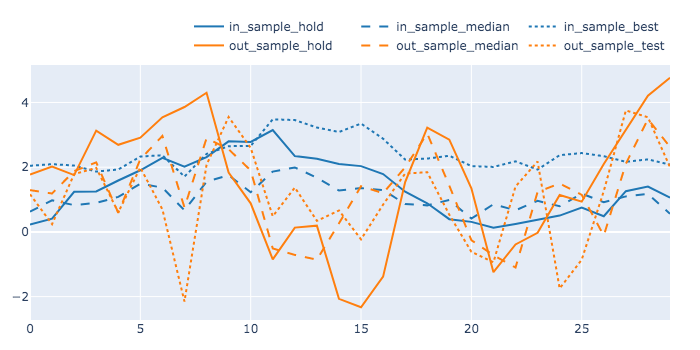

In [23]:
cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=vbt.settings.color_schema['blue']),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dot'),
        dict(line_color=vbt.settings.color_schema['orange']),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dot')
    ]
).show_png()


